# News Article Summarization and Keyword Extraction via NLP

In this demo, we will create an NLP pipeline that will summarize and extract keywords from a news article URL. We will be using state-of-the-art transformer models such as BERT to perform these NLP tasks.

Additionally, we will be using MLRun's real-time inference graphs to create the pipeline. This allows for easy containerization and deployment of our pipeline on top of a production-ready Kubernetes cluster.

The full pipeline will do the following:
1. Retrieve news article text and metadata from URL using newspaper3k
2. Summarize article text via Huggingface pipeline using DistilBart model
3. Extract article keywords via KeyBERT using BERT-embeddings and cosine similarity
4. Remove the original article text from the response (optional)
5. Persist record in KV table

### Install Local Dependencies

In [1]:
!pip install transformers==4.11.3 newspaper3k==0.2.8 keybert==0.5.0

### Define MLRun Function
Here we define the serverless function that will containerize and deploy our application. We can add dependencies and commands to the image build, define replicas for scaling, add environment variables, and more.

In [2]:
import os
import mlrun

In [3]:
project_name = "nlp-demo"
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2022-11-10 14:45:18,290 [info] loaded project nlp-demo from MLRun DB


In [4]:
fn = mlrun.code_to_function(name="news-article-nlp", filename="nlp_transformations.py",
                            kind="serving", image='mlrun/ml-models')
fn.spec.min_replicas = 1
fn.spec.max_replicas = 1
fn.spec.build.commands = [
    "python -m pip install transformers==4.11.3 newspaper3k==0.2.8 keybert==0.5.0",
    "python -c 'from transformers import pipeline; pipeline(\"summarization\")'",
    "python -c 'from keybert import KeyBERT; KeyBERT()'"
]

### Define Real-Time Serving Graph
Here we will orchestrate the functions and classes we want to run in our pipeline. The source code for these functions is located in `project/nlp_transformations.py`. Notice, this is the same file we used when running `code_to_function` in the cell above.

In [5]:
container = "bigdata"
table_path = f"nlp-{os.getenv('V3IO_USERNAME')}"
key = "title"

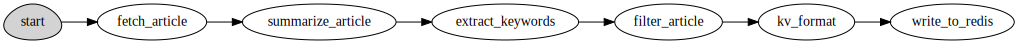

In [6]:
graph = fn.set_topology("flow", engine="async")

graph.to(name="fetch_article", handler="fetch_article")\
     .to(name="summarize_article", class_name="SummarizeArticle")\
     .to(name="extract_keywords", class_name="ExtractKeywords")\
     .to(name="filter_article", handler="filter_article")\
     .to(name="kv_format", handler="kv_format", full_event=True)

# On Iguazio's setup, V3IO fuse is enabled and using storey's steps we can write data to a KV table.
# when using community-edition, Redis service has to be deployed, and using mlrun's redisnosql target
# create a custom additional writing step.

if os.environ.get('V3IO_ACCESS_KEY'):
    graph.add_step(name="write_to_kv", class_name="storey.NoSqlTarget", table=f"v3io:///{container}/{table_path}", after='kv_format').respond()
    
else: # writing to redis
    graph.add_step(name="write_to_redis",handler="write_to_redis", after='kv_format', full_event=True)

graph.plot(rankdir='LR')

### Test the Pipeline Locally (using simulator)

In [7]:
# import the step functions for simulation
from nlp_transformations import *

# setting redis url
if not os.environ.get("MLRUN_REDIS_URL"):
    os.environ["MLRUN_REDIS_URL"] = "redis-master:6379" # Put your redis url here, for example 191.162.213.164:32594
    os.environ["MLRUN_REDIS_PASS"] = '' # Put your redis password for auth, for example 2VjrMTBM6r

# create a mock server (simulator)
server = fn.to_mock_server()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [8]:
# test the pipeline
server.test("/", body={"url" : "https://edition.cnn.com/2022/10/23/motorsport/dietrich-mateschitz-tributes-red-bull-spt-intl/index.html"})

{'id': '5d597637a273489f8afc2229c590d7f9'}

### Containerize and Deploy Pipeline on K8s
Here we easily containerize and deploy our application to our K8s cluster with a single command.

In [9]:
fn.spec.readinessTimeoutSeconds = 60 * 20  # 20 minutes.\n",
fn.deploy()

> 2022-11-10 14:45:25,281 [info] Starting remote function deploy
2022-11-10 14:45:25  (info) Deploying function
2022-11-10 14:45:25  (info) Building
2022-11-10 14:45:25  (info) Staging files and preparing base images
2022-11-10 14:45:26  (info) Building processor image
2022-11-10 14:47:46  (info) Build complete
2022-11-10 14:47:58  (info) Function deploy complete
> 2022-11-10 14:47:59,046 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['localhost:30711']}


'http://localhost:30711'

### Test Pipeline with URLs From Various News Sources 
Here we can test the pipeline with various news sources. This pipeline should work with any source compatible with the `newspaper3k` Python library.

In [10]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html"}
)

> 2022-11-10 14:47:59,123 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080/'}


{'id': '10401b96-5197-4ed8-914a-79e05356a98f'}

In [11]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/23/entertainment/matthew-perry-jennifer-aniston-alcohol/index.html"}
)

> 2022-11-10 14:47:59,133 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080/'}


{'id': 'af074451-eddb-4c0f-af9d-0848887f95c6'}

In [12]:
fn.invoke(
    path="/",
    body={"url" : "https://www.npr.org/2022/10/24/1130915534/the-houston-astros-and-philadelphia-phillies-will-face-each-other-in-the-world-s"}
)

> 2022-11-10 14:47:59,142 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080/'}


{'id': '5981ccf6-a371-4fd5-a02d-05f15dd70a30'}

In [13]:
fn.invoke(
    path="/",
    body={"url" : "https://abcnews.go.com/Politics/jan-committee-trumps-testimony-circus-cheney/story?id=91963586",
          "filter_article" : False}
)

> 2022-11-10 14:47:59,149 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080/'}


{'id': 'b1f3f28d-9fa3-4ffc-9248-0379d9bee25a'}

### Define KV Table Schema for Dashboard
While a schema is not required to write records to a table, it is required for the table to be displayed in a Grafana dashboard.

In [14]:
if os.environ.get('V3IO_ACCESS_KEY') :

    print ("creating key value schema")

    import v3io.dataplane

    v3io_client = v3io.dataplane.Client()

    v3io_client.kv.create_schema(
        container=container,
        table_path=table_path,
        key=key,
        fields = [
            {'name': 'url',
             'type': 'string',
             'nullable': False},
            {'name': 'filter_article',
             'type': 'boolean',
             'nullable': False},
            {'name': 'title',
             'type': 'string',
             'nullable': False},
            {'name': 'authors',
             'type': 'string',
             'nullable': False},
            {'name': 'publish_date',
             'type': 'string',
             'nullable': False},
            {'name': 'original_text',
             'type': 'string',
             'nullable': False},
            {'name': 'summarized_text',
             'type': 'string',
             'nullable': False},
            {'name': 'keywords',
             'type': 'string',
             'nullable': False}
        ]
    )

### View Dashboard

After using the pipeline, we will be able to visualize the article summary, keywords, and metadata in a Grafana dashboard. The JSON file for the dashboard is available under `grafana_dashboard.json`.

After importing into Grafana and running the pipeline above, the dashboard will look something like the following:
![](./dashboard_preview.png)